# Correlation between character number of lines per episode and imdb episode ratings for _The Office_

## Load data and packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

In [2]:
lines_df = pd.read_csv("../The_Office_lines.csv")
rating_df = pd.read_csv("../TheOfficeIMDBPerEpisode.csv")

## Process data

In [3]:
## Lines

# gather number of lines per character per episode
n_lines_df = lines_df.groupby(['season','episode','speaker'])\
    .count()['line_text']\
    .reset_index()\
    .sort_values(['season','episode','line_text'])\
    .reset_index(drop=True)
n_lines_df.columns = ['Season','Episode','Speaker','n_lines']


## Ratings

# verify episodes are sorted correctly
assert all(rating_df.sort_values(by="AirDate") == rating_df)

# attach episode numbers
n_seasons = rating_df['Season'].max()
n_episodes = rating_df.shape[0]
episode_num = [1]*n_episodes
last_ep = 0
season_of_last_ep = 0
for i in range(n_episodes):
    season_of_this_ep = rating_df['Season'][i]
    if season_of_this_ep > season_of_last_ep:
        this_ep = 1
    else:
        this_ep = last_ep + 1
    last_ep = this_ep
    season_of_last_ep = season_of_this_ep
    episode_num[i] = this_ep
rating_df['Episode'] = episode_num
rating_per_episode_df = rating_df[['Season','Episode','Rating']]

## Join dataframes
ratings_and_lines_df = pd.merge(n_lines_df, 
                                rating_per_episode_df,
                                on=['Season','Episode'], 
                                how='right')

ratings_and_lines_df['Season_Episode'] = list(zip(ratings_and_lines_df['Season'].values,
         ratings_and_lines_df['Episode'].values))

In [4]:
# character cleanup
speakers = ['a']*len(ratings_and_lines_df['Speaker'])
for i in range(len(speakers)):
    if ratings_and_lines_df['Speaker'].values[i] == 'Packer':
        ratings_and_lines_df['Speaker'].values[i] = 'Todd Packer'
    if ratings_and_lines_df['Speaker'].values[i] == 'Todd':
        ratings_and_lines_df['Speaker'].values[i] = 'Todd Packer'
    if ratings_and_lines_df['Speaker'].values[i] == 'DeAngelo':
        ratings_and_lines_df.loc[i,'Speaker'] = 'Deangelo'
    if ratings_and_lines_df['Speaker'].values[i] == 'David Wallace':
        ratings_and_lines_df.loc[i,'Speaker'] = 'David'
    if ratings_and_lines_df['Speaker'].values[i] == 'Pete':
        if ratings_and_lines_df['Season'].values[i] < 9:
            ratings_and_lines_df.loc[i,'Speaker'] = None
    if ratings_and_lines_df['Speaker'].values[i] == 'Clark':
        if ratings_and_lines_df['Season'].values[i] < 9:
            ratings_and_lines_df.loc[i,'Speaker'] = None
    if ratings_and_lines_df['Speaker'].values[i] == 'Robert California':
        ratings_and_lines_df['Speaker'].values[i] = 'Robert'
    if ratings_and_lines_df['Speaker'].values[i] == 'Robert':
        if ratings_and_lines_df['Season_Episode'].values[i] == (7,11):
            ratings_and_lines_df.loc[i,'Speaker'] = None

In [5]:
# get characters who appeared in the most episodes
character_line_counts = ratings_and_lines_df.groupby(['Speaker'])\
    .nunique()['Season_Episode']\
    .reset_index()\
    .sort_values('Season_Episode', ascending=False)\
    .reset_index(drop=True)
characters = [x for x in character_line_counts['Speaker'].values[:30] if x not in ['All','Everyone','Man','Guy']]

In [6]:
# get correlations and p values
combined_df = ratings_and_lines_df.copy()
coefs = []
p_vals = []
for character in characters:
    char_df = combined_df.loc[combined_df['Speaker']==character,:]
    y = char_df["Rating"]
    X = char_df["n_lines"]
    y = y[~np.isnan(X)]
    X = X[~np.isnan(X)]
    coefs.append(pearsonr(X,y)[0])
    p_vals.append(pearsonr(X,y)[1])
coef_dict = {'Character': characters, 'Coefficient': coefs, 'p Value': p_vals}
coef_df = pd.DataFrame.from_dict(coef_dict).sort_values('Coefficient', ascending=False).reset_index(drop=True)

## Plot

In [7]:
# place '*' next to character name if p < .1
coef_df['Character*'] = [coef_df['Character'][i] + '*' if coef_df['p Value'][i] > .1 else coef_df['Character'][i] + '' for i in range(len(coef_df['p Value']))]

In [8]:
# https://stackoverflow.com/questions/36271302/changing-color-scale-in-seaborn-bar-plot
def colors_from_values(values, palette_name):
    indices = pd.Series([26,25,25,24,24,23,22,22,21,20,19,19,18,17,16,16,15]+[14,13,12,11,9,9,7,6,4,3])
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

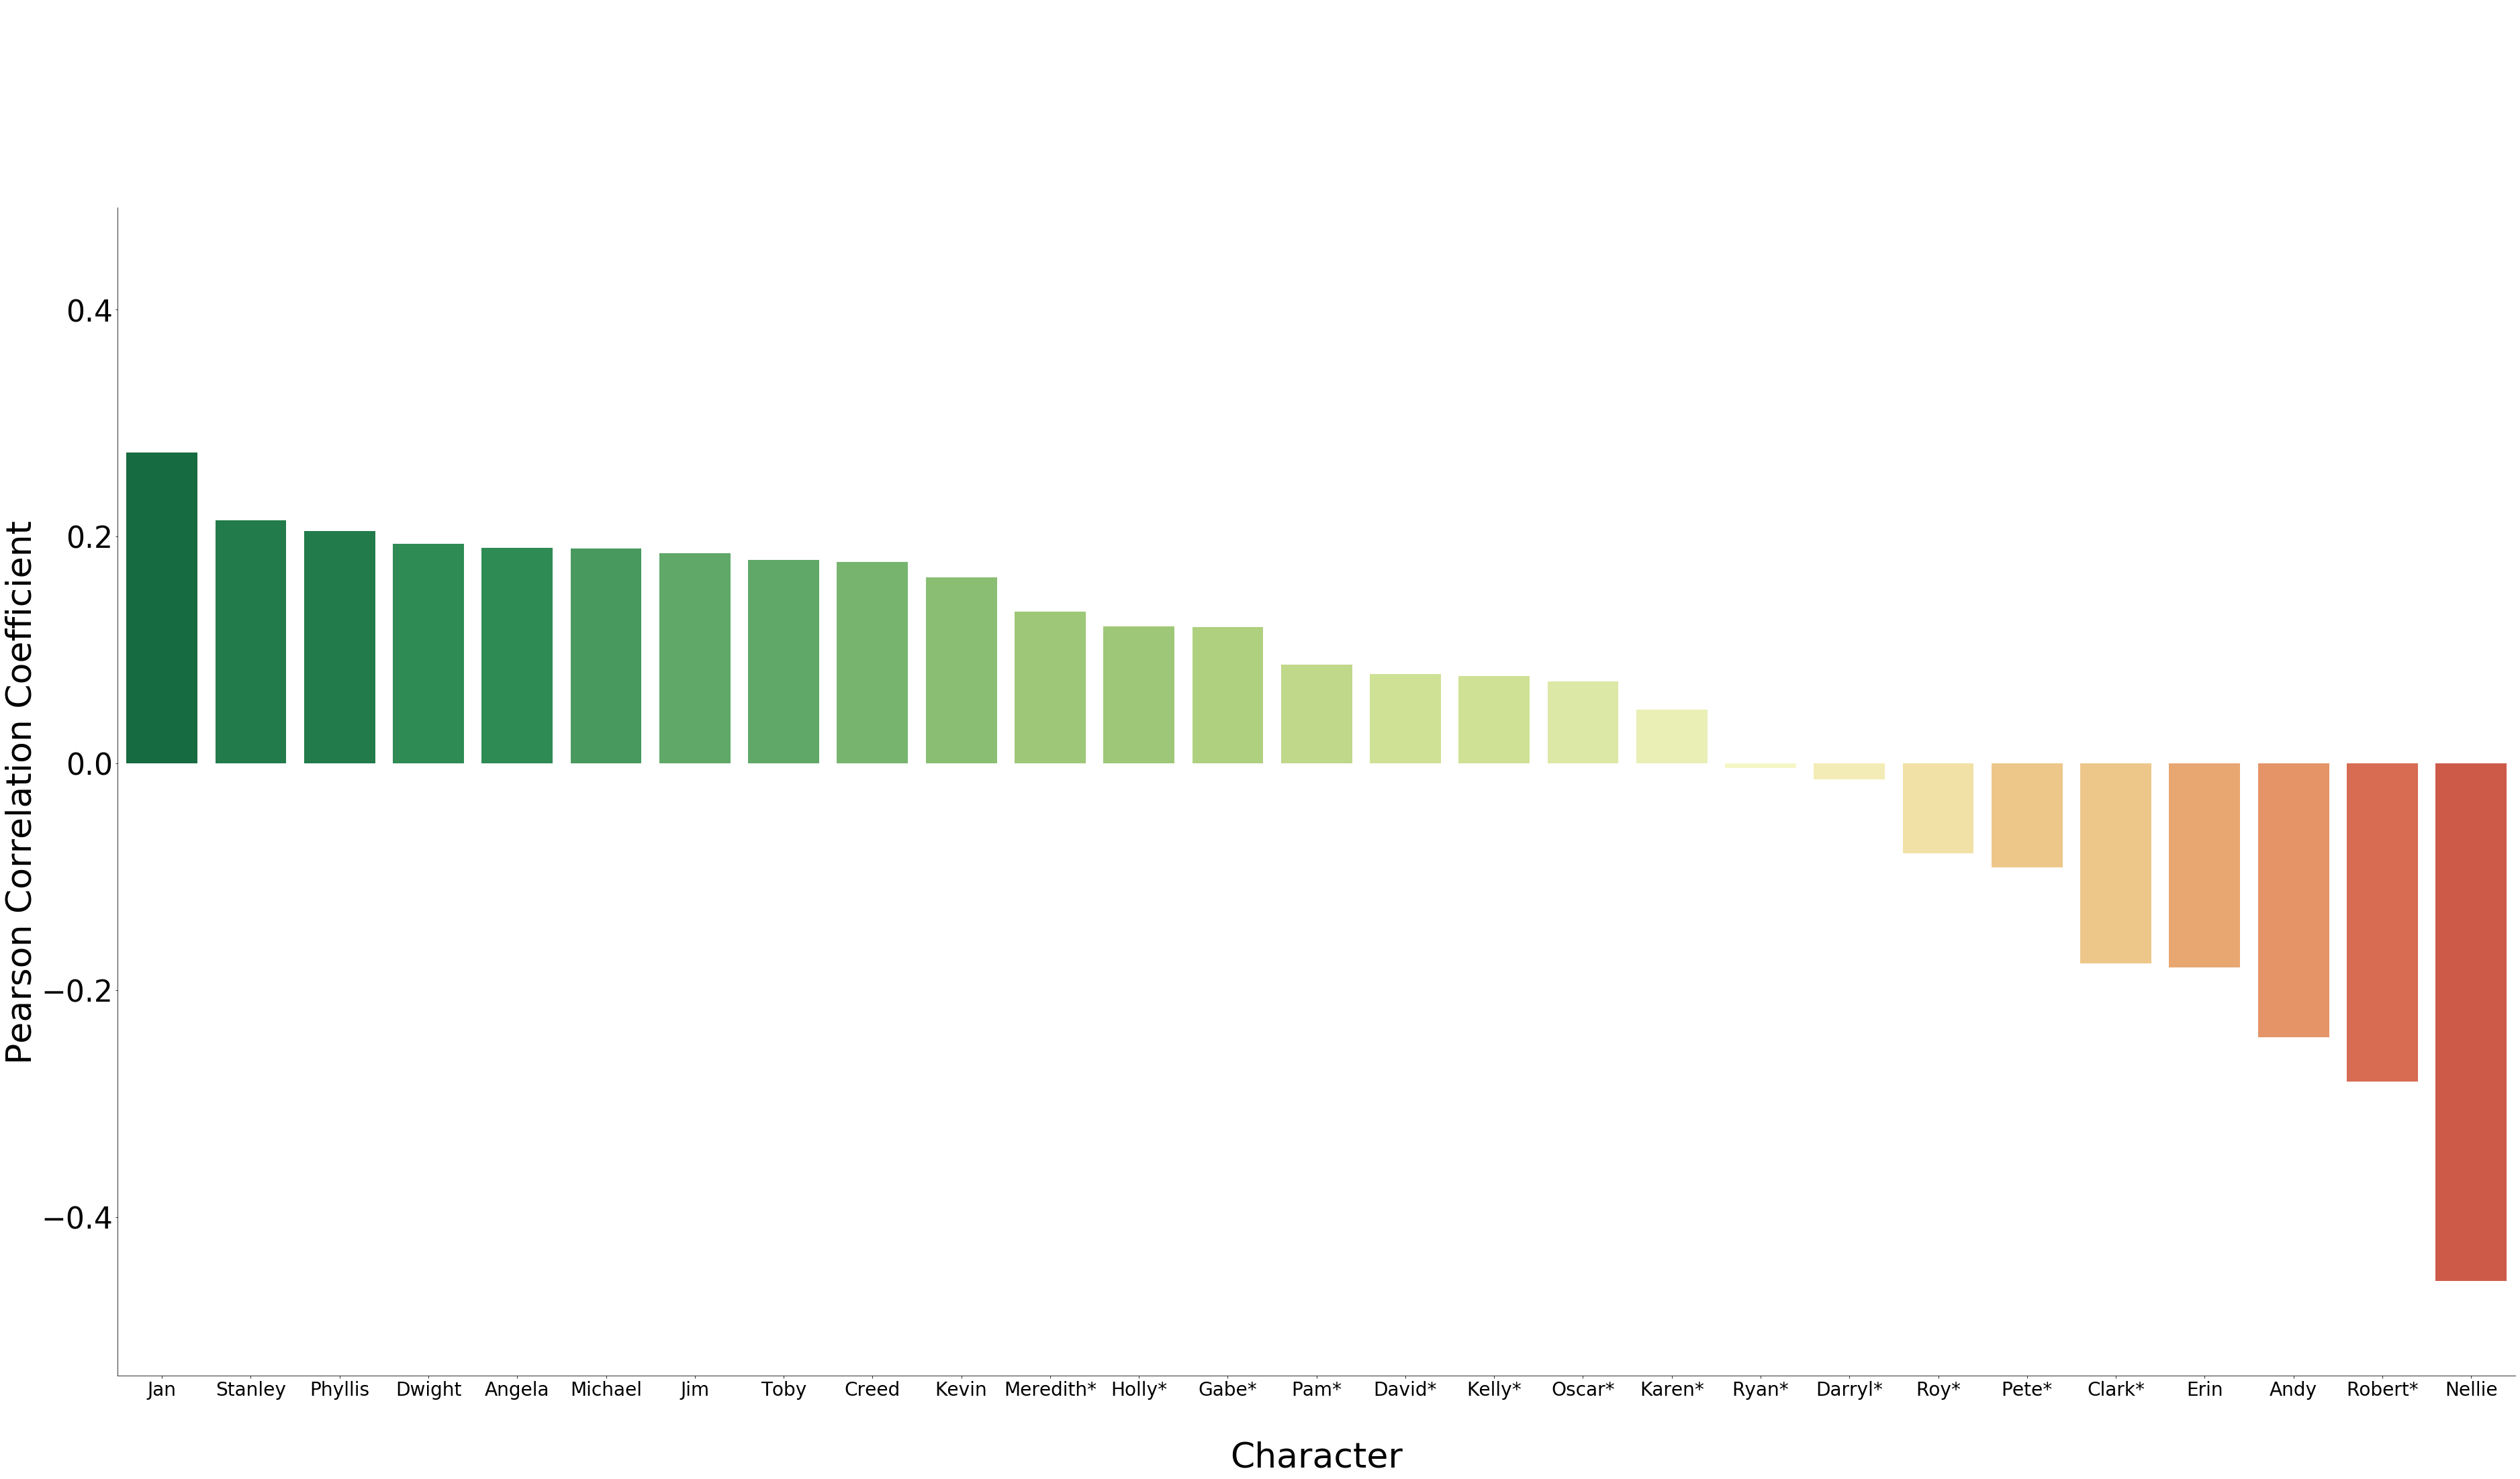

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(64, 32)
sns.despine()
ax.set_ylim(-.54,.49)
sns.barplot(x=coef_df["Character*"], y=coef_df["Coefficient"], ax=ax, orient='v', palette=colors_from_values(coef_df["Coefficient"], "RdYlGn"))
plt.xlabel('\nCharacter', size=52)
plt.ylabel('Pearson Correlation Coefficient', size=52)
plt.xticks(rotation=0, size=28)
plt.yticks(size=44)
plt.title(' ', size=3, loc='left', pad=300)
fig.savefig("influence.png", bbox_inches='tight')

## Character scatter plots with regression line, for reference

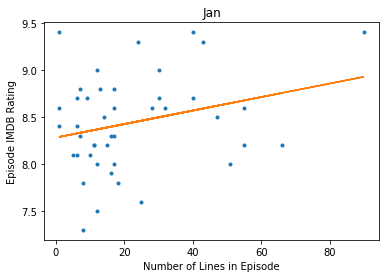

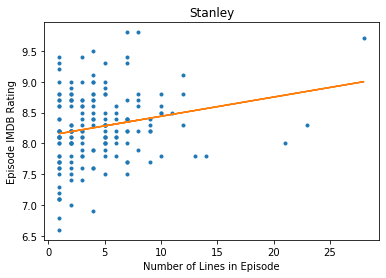

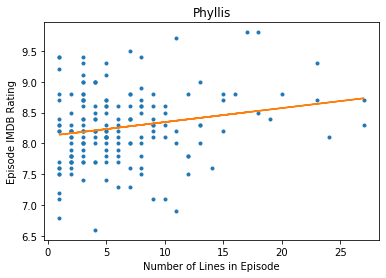

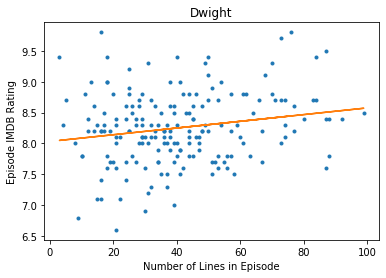

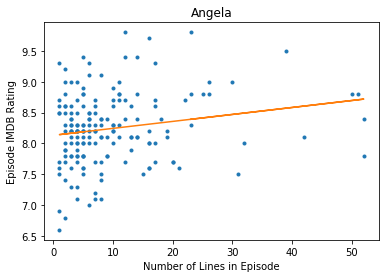

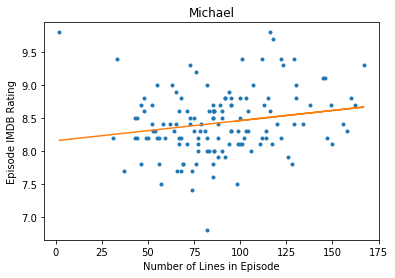

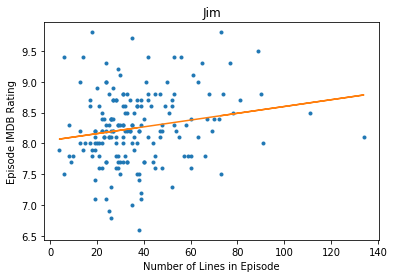

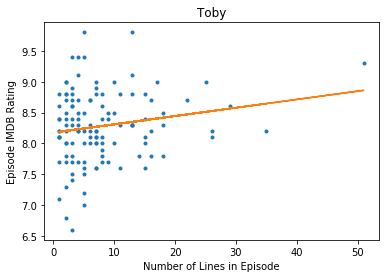

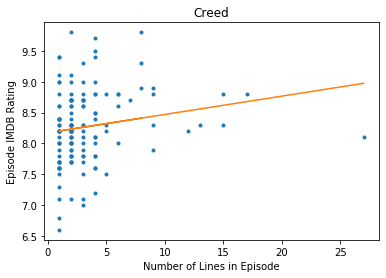

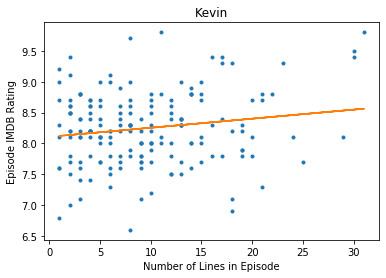

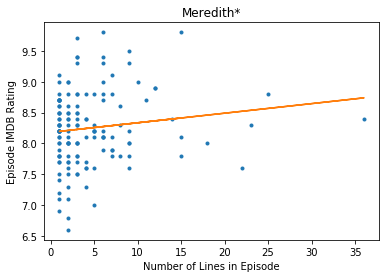

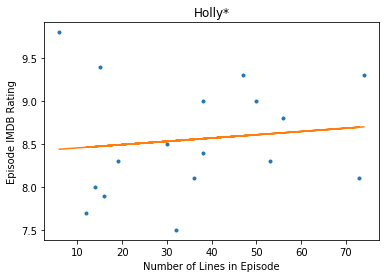

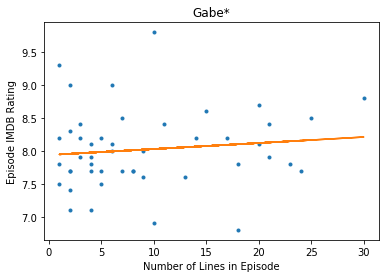

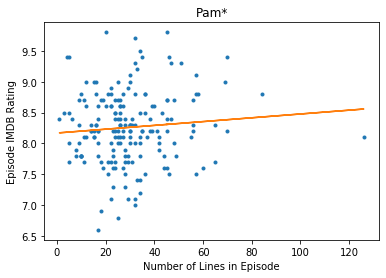

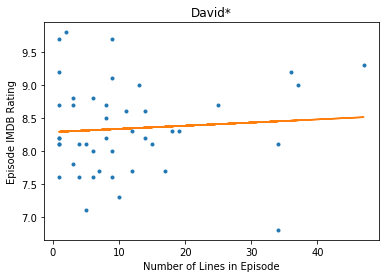

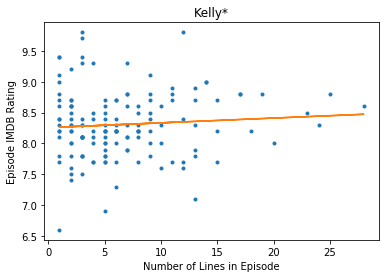

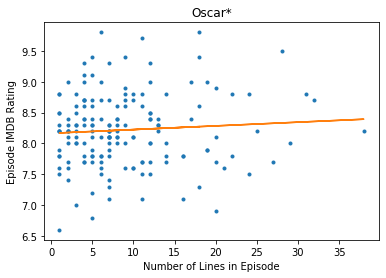

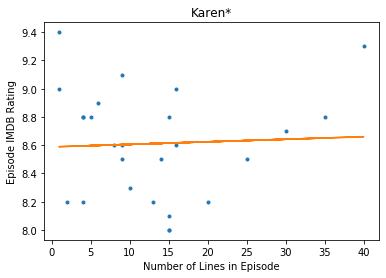

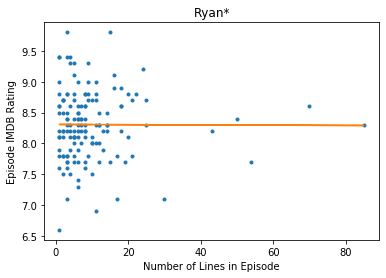

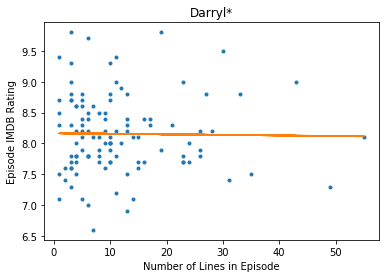

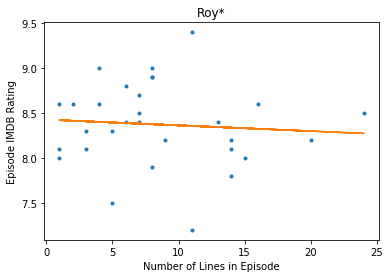

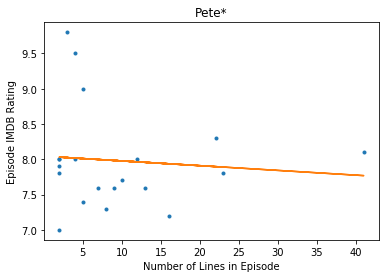

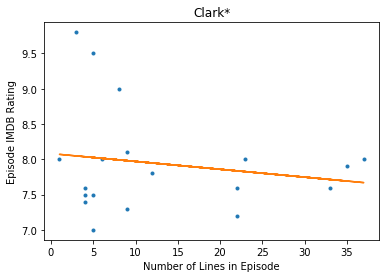

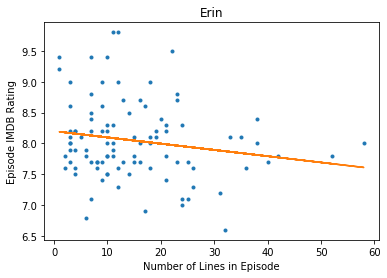

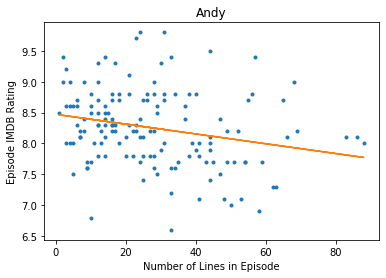

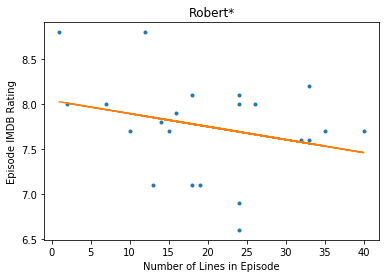

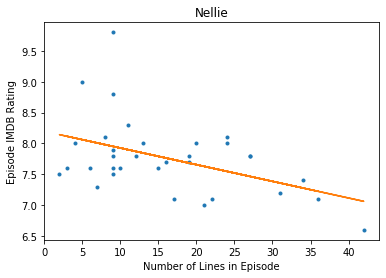

In [10]:
combined_df = ratings_and_lines_df.copy()
for character in coef_df['Character*']:
    char_df = combined_df.loc[combined_df['Speaker']==''.join([x for x in character if x != '*']),:]
    y = char_df["Rating"]
    X = char_df["n_lines"]
    y = y[~np.isnan(X)]
    X = X[~np.isnan(X)]
    m, b = np.polyfit(X, y, 1)
    
    plt.plot(X,y,'.')
    plt.plot(X, m*X + b)
    plt.xlabel('Number of Lines in Episode')
    plt.ylabel('Episode IMDB Rating')
    plt.title(f'{character}')
    plt.show()